# Grid-based Random Simulation with KISS-GP in Oyama Data
simulation of altitudes in a subarea of the Oyama data with `RandomInGrid` and KISS-GP

In [1]:
import gpytorch as gpt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

from sparcity import Coord, subarea, TestData
from sparcity.dataset import load_oyama
from sparcity.gaussian_process import KISSGPRegression
from sparcity.metrics import absolute_error
from sparcity.metrics import mean_absolute_error_score as mae
from sparcity.random import random_coord
from sparcity.sampler import RandomInGrid

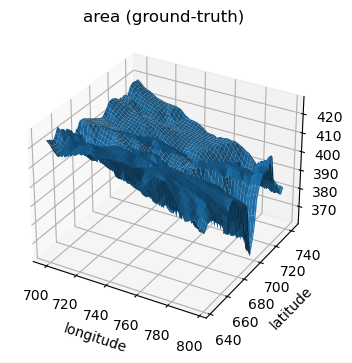

In [2]:
# Make area with oyama data

oyama = load_oyama(as_Coord=True)
area = subarea(*random_coord(oyama, 123), length=100, field=oyama)

fig = plt.figure(figsize=(4, 4), facecolor="w")
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(**area())
ax.set(xlabel="longitude", ylabel="latitude", title="area (ground-truth)");


`RandomInGrid` with 10x10 samples (subarea size: 3x3)

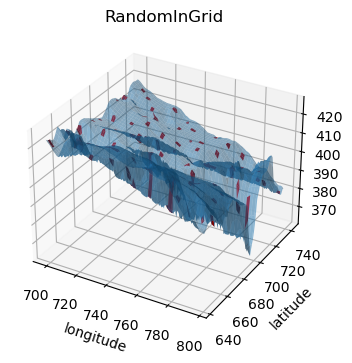

In [3]:
# Make training data set with RandomInGrid class

train = RandomInGrid(n_x=10, n_y=10, length=3, field=area, seed=0)

fig = plt.figure(figsize=(4, 4), facecolor="w")
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(**train.patch(), color="r")
ax.plot_surface(**area(), alpha=0.5)
ax.set(xlabel="longitude", ylabel="latitude", title="RandomInGrid");

In [4]:
# Make KISS-GP Regression model

model = KISSGPRegression(traindata=train)
model.fit(n_iter=100)

Optimization: 100%|██████████| 100/100 [00:08<00:00, 12.07it/s]


In [5]:
# predict all the area

test = TestData(area)
pred = model.predict(test)

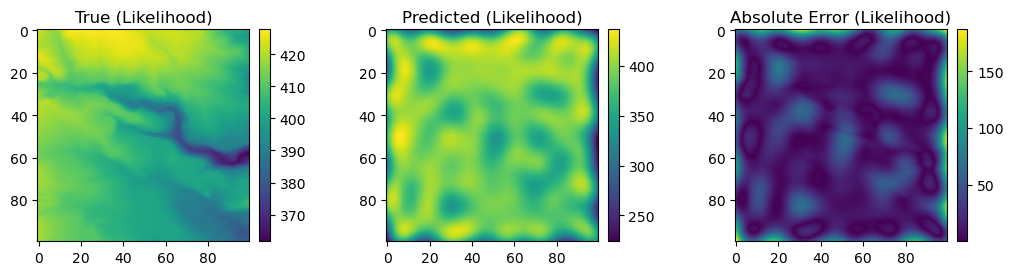

In [6]:
# Visualize result

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
plt.subplots_adjust(wspace=0.5)

for (i, v), title in zip(
    enumerate([
        test.field.z, pred.z, absolute_error(pred, test.field).z
    ]),
    ["True", "Predicted", "Absolute Error"]
):
    im = ax[i].imshow(v, cmap="viridis")
    ax[i].set(title=f"{title} (Likelihood)")
    cax = make_axes_locatable(
        ax[i]
    ).append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax)

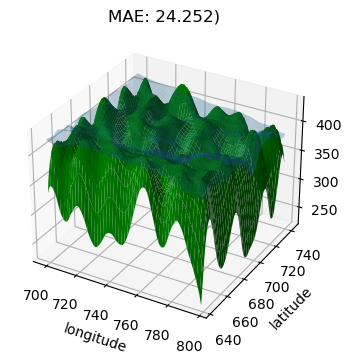

In [7]:
# Visualize with MAE

fig = plt.figure(figsize=(4, 4), facecolor="w")
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(**pred(), color="g")
ax.plot_surface(**area(), alpha=0.3)
ax.set(
    xlabel="longitude",
    ylabel="latitude",
    title=f"MAE: {(mae(pred, test.field)).round(3)})"
);